![picture](https://doc.google.com/uc?id=1-SCmtVCHxEXXpBfRMwvY_gBrDFA6Pb3u)
# **The Tomato Leaf Disease Type Classification Project**

## Evaluation of the classifier

We first need to load the required libraries


In [1]:
%load_ext autoreload
%autoreload 2

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import resnet50
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [2]:
#set the model type that you will train in this notebook
TYPE='type'
model_type='resnet50'
#set your user name
user='byju'
iteration='1'   # This value actually must be set to 1, 2, 3, 4 etc. on first, 2nd, 3rd , 4th run and so on of this script.

#NOTE: Make sure to set the correct project path with respect to your Google Drive

PROJECT_PATH='/content/drive/MyDrive/TLDArchive2/tomato2/'
print('PROJECT_PATH: ',PROJECT_PATH)

HDF5_DATASET_PATH=PROJECT_PATH+'h5-dataset/tomato-disease-type-dataset-SIZE224-train-dev-test-v2.hdf5'
print(HDF5_DATASET_PATH)

#ACCURACY_LOSS_OUPUT_FILE=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-accuracy-loss-'+user+'-'+iteration+'.jpg'
#print('ACCURACY_LOSS_OUPUT_FILE: ', ACCURACY_LOSS_OUPUT_FILE)

TRAINED_MODEL=PROJECT_PATH+"td_model_cnn.h5"
print('TRAINED_MODEL: ',TRAINED_MODEL)

#CHECKPOINT_PATH = PROJECT_PATH+'checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'
CHECKPOINT_PATH = PROJECT_PATH+"td_model_cnn.h5"   # Not a check oiint model, but set so for the convenience of running this script with out breaking
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)

#LOGFILE_PATH=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'
#print('LOGFILE_PATH: ',LOGFILE_PATH)


PROJECT_PATH:  /content/drive/MyDrive/TLDArchive2/tomato2/
/content/drive/MyDrive/TLDArchive2/tomato2/h5-dataset/tomato-disease-type-dataset-SIZE224-train-dev-test-v2.hdf5
TRAINED_MODEL:  /content/drive/MyDrive/TLDArchive2/tomato2/td_model_cnn.h5
CHECKPOINT_PATH:  /content/drive/MyDrive/TLDArchive2/tomato2/td_model_cnn.h5


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
sys.path.append('/content/drive/MyDrive/TLDArchive2/')
import anis_koubaa_udemy_computer_vision_lib  
from anis_koubaa_udemy_computer_vision_lib import *

# **Load the Dataset**

In [5]:
def load_dataset_from_hdf5_file(hdf_file_path):
  hf = h5py.File(hdf_file_path, "r")
  trainX= np.array(hf["trainX"]).astype("f8")
  ascii_train_labels = np.array(hf["trainLabels"]).astype("S65")
  trainY=np.array(hf["trainY"]).astype("int")

  devX= np.array(hf["devX"]).astype("f8")
  ascii_dev_labels = np.array(hf["devLabels"]).astype("S65")
  devY=np.array(hf["devY"]).astype("int")

  testX= np.array(hf["testX"]).astype("f8")
  ascii_test_labels = np.array(hf["testLabels"]).astype("S65")
  testY=np.array(hf["testY"]).astype("int")

  trainLabels = np.array([n.decode('unicode_escape') for n in ascii_train_labels])
  devLabels = np.array([n.decode('unicode_escape') for n in ascii_dev_labels])
  testLabels = np.array([n.decode('unicode_escape') for n in ascii_test_labels])

  print("trainX.shape: ",trainX.shape)
  print("trainY.shape: ",trainY.shape)
  print("trainLabels.shape: ",trainLabels.shape)
  print("devX.shape: ",devX.shape)
  print("devY.shape: ",devY.shape)
  print("devLabels.shape: ",devLabels.shape)
  print("testX.shape: ",testX.shape)
  print("testY.shape: ",testY.shape)
  print("testLabels.shape: ",testLabels.shape)

  return trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels

In [6]:
def load_dev_test_dataset_from_hdf5_file(hdf_file_path):
  hf = h5py.File(hdf_file_path, "r")

  devX= np.array(hf["devX"]).astype("f8")
  ascii_dev_labels = np.array(hf["devLabels"]).astype("S65")
  devY=np.array(hf["devY"]).astype("int")

  testX= np.array(hf["testX"]).astype("f8")
  ascii_test_labels = np.array(hf["testLabels"]).astype("S65")
  testY=np.array(hf["testY"]).astype("int")


  devLabels = np.array([n.decode('unicode_escape') for n in ascii_dev_labels])
  testLabels = np.array([n.decode('unicode_escape') for n in ascii_test_labels])


  print("devX.shape: ",devX.shape)
  print("devY.shape: ",devY.shape)
  print("devLabels.shape: ",devLabels.shape)
  print("testX.shape: ",testX.shape)
  print("testY.shape: ",testY.shape)
  print("testLabels.shape: ",testLabels.shape)

  return devX,devY,devLabels,testX,testY,testLabels

In [7]:
import datetime
t0 = datetime.datetime.now()
devX,devY,devLabels,testX,testY,testLabels=load_dev_test_dataset_from_hdf5_file(HDF5_DATASET_PATH)
t1 = datetime.datetime.now()
print('time to load data: ', (t1-t0))

devX.shape:  (1079, 224, 224, 3)
devY.shape:  (1079, 10)
devLabels.shape:  (1079,)
testX.shape:  (1080, 224, 224, 3)
testY.shape:  (1080, 10)
testLabels.shape:  (1080,)
time to load data:  0:00:13.953925


In [8]:
IMAGE_SIZE=testX.shape[1]
print(IMAGE_SIZE)

224


# **Dataset Visualization**

In [9]:
# we have not loaded trainX and trainY (see above cell); so we comment below line
#anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(trainX, trainLabels,rows=2, colums=5, width=20,height=8)


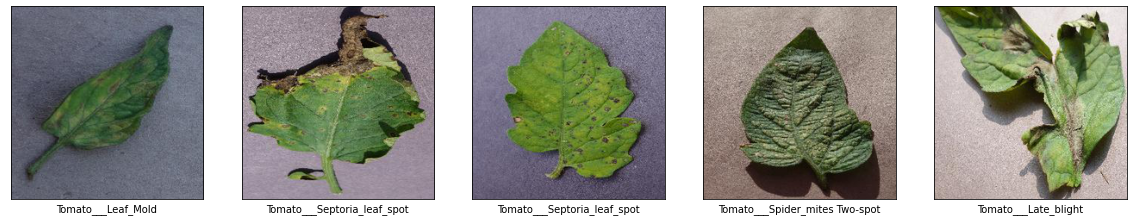

In [10]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX, devLabels,rows=1, colums=5, width=20,height=8)

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


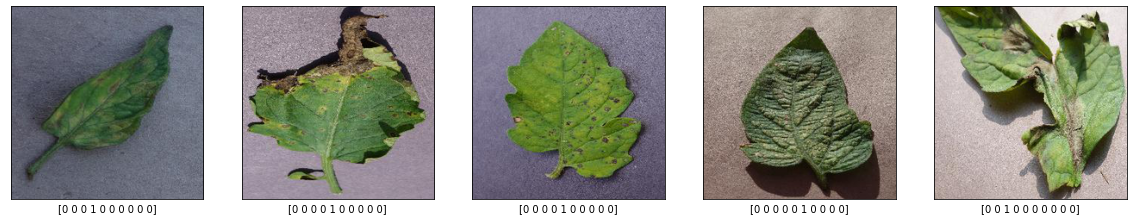

In [11]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX, devY,rows=1, colums=5, width=20,height=8)

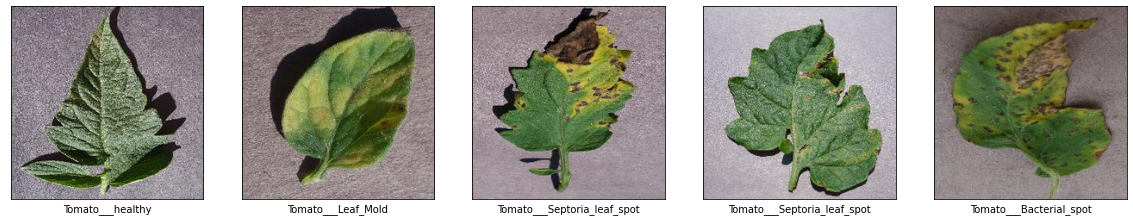

In [12]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX, testLabels,rows=1, colums=5, width=20,height=8)

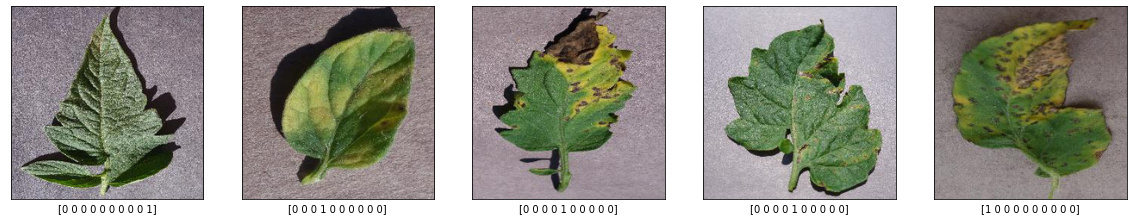

In [13]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX, testY,rows=1, colums=5, width=20,height=8)

In [14]:
# Convert to TF Serving

In [15]:
#print('Loading the best model...')
#model = tf.keras.models.load_model(CHECKPOINT_PATH)

In [16]:
#tf.compat.v1.keras.experimental.export_saved_model(model, PROJECT_PATH+'tensorflow-serving-models-by-147-generation-98')

# **Make Predictions**

In [17]:
print('Loading the best model...', TRAINED_MODEL)
t0 = datetime.datetime.now()
test_model = tf.keras.models.load_model(PROJECT_PATH+"td_model_cnn.h5")
t1 = datetime.datetime.now()
print('time to load the model: ', (t1-t0))

Loading the best model... /content/drive/MyDrive/TLDArchive2/tomato2/td_model_cnn.h5
time to load the model:  0:00:04.200230


In [18]:
# make predictions on the validation dataset
print("[INFO] evaluating network on the dev dataset...")
test_model.evaluate(devX, devY,verbose=0)



[INFO] evaluating network on the dev dataset...


[0.14634732902050018, 0.960148274898529]

In [19]:
# make predictions on the test dataset
print("[INFO] evaluating network on the test dataset...")
test_model.evaluate(testX, testY,verbose=0)

[INFO] evaluating network on the test dataset...


[0.14995300769805908, 0.949999988079071]

In [20]:
def get_data_classes_dict(databinaryoutput,datalabels):
    # note that this function doesnot use first input
    number_of_classes=np.unique(datalabels).size
    #classlist = list(range(0, number_of_classes))
    classval=np.unique(np.argmax(LabelBinarizer().fit_transform(datalabels), axis=1))
    class_dict={}
    for A, B in zip(classval, np.unique(datalabels)):
      class_dict[A] = B
    #print(class_dict)
    return class_dict,number_of_classes

In [21]:
class_dict,number_of_classes=get_data_classes_dict(testY,testLabels)
class_dict

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spot',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Cu',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

In [ ]:
#testlist = list(range(0, 10))
#print(testlist)

In [ ]:
#from sklearn.preprocessing import LabelBinarizer
#lb = LabelBinarizer()
#lb.fit_transform(testLabels)

In [ ]:
#min(np.argmax(LabelBinarizer().fit_transform(testLabels), axis=1)) # returns 0

In [ ]:
#max(np.argmax(LabelBinarizer().fit_transform(testLabels), axis=1)) # returns 9

In [ ]:
#np.unique(np.argmax(LabelBinarizer().fit_transform(testLabels), axis=1))

In [ ]:
#testY


In [22]:
np.unique(testLabels)

array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Leaf_Mold',
       'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spot',
       'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Cu',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U30')

In [23]:
class_dict,number_of_classes=get_data_classes_dict(testY,testLabels)
class_dict

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spot',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Cu',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

In [24]:
class_dict[6]

'Tomato___Target_Spot'

In [25]:
len(class_dict)

10

In [26]:
len(class_dict)

10

# **Testing on one image**

[0 0 0 0 0 0 0 1 0 0]
Tomato___Tomato_Yellow_Leaf_Cu
Label = Tomato___Tomato_Yellow_Leaf_Cu
image shape:  (224, 224, 3)


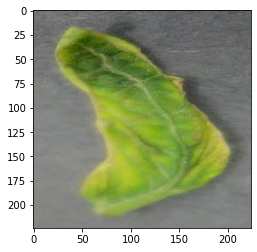

In [27]:
index= 84                     #30
test_image = testX[index]
print(testY[index])
print(class_dict[np.argmax(testY[index])])
anis_koubaa_udemy_computer_vision_lib.display_image(testX, testLabels, index)


In [28]:
import datetime


1/1 [==============================] - 0s 319ms/step
-----------------------------------------
prediction time:  0:00:00.373707
true label:  [0 0 0 0 0 0 0 1 0 0]
predicted label:  7
Leaf Disease Type:  Tomato___Tomato_Yellow_Leaf_Cu
Leaf Disease Type Predicted:  Tomato___Tomato_Yellow_Leaf_Cu
Confidence:  0.9866731
-----------------------------------------


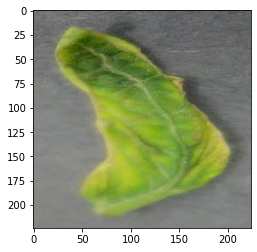

In [29]:
plt.imshow(test_image)
#reshaped_image=anis_koubaa_udemy_computer_vision_lib.reshape_image_for_neural_network_input(test_image,IMAGE_SIZE=224, 
#                                                                                   normalize=False)#must be false because already normalized

from PIL import Image
from tensorflow.keras.utils import img_to_array
import cv2
t0 = datetime.datetime.now()
IMAGE_SIZE = 224
img = cv2.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
reshaped_image = img.reshape(1, 224, 224, 3)
prediction_array = test_model.predict(reshaped_image)
t1 = datetime.datetime.now()
print('-----------------------------------------')
print ("prediction time: ", t1-t0)
print ("true label: ", testY[index])
print ("predicted label: ", np.argmax(prediction_array[0]))
print ("Leaf Disease Type: ",class_dict[np.argmax(testY[index])])
print ("Leaf Disease Type Predicted: ",class_dict[np.argmax(prediction_array[0])])
print ("Confidence: ",prediction_array[0][np.argmax(prediction_array[0])]) # confidence is the probability of that outcome predicted
print('-----------------------------------------')


In [30]:
prediction_array[0]

array([1.1390710e-02, 8.7526583e-05, 8.8980416e-04, 4.1353010e-04,
       1.7169688e-04, 2.5065275e-04, 6.3714265e-06, 9.8667312e-01,
       5.1386061e-05, 6.5216911e-05], dtype=float32)

In [ ]:
np.argmax(prediction_array[0])

0

In [31]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predicted_label = np.argmax(testY[index])
print("true label: ", np.argmax(prediction_array[0]))
print("predicted label: ", predicted_label)

true label:  7
predicted label:  7


In [32]:
#reshaped_test_image = anis_koubaa_udemy_computer_vision_lib.reshape_image_for_neural_network_input(testX[index], IMAGE_SIZE=224,normalize=False)
reshaped_test_image = reshaped_image
p = test_model.predict(reshaped_test_image)
print(p)
class_dict[np.argmax(p[0])]

1/1 [==============================] - 0s 20ms/step
[[1.1390710e-02 8.7526583e-05 8.8980416e-04 4.1353010e-04 1.7169688e-04
  2.5065275e-04 6.3714265e-06 9.8667312e-01 5.1386061e-05 6.5216911e-05]]


'Tomato___Tomato_Yellow_Leaf_Cu'

# **Testing with the whole dataset**

In [33]:
prediction_array_all_test_dataset = test_model.predict(testX, verbose=1)
predicted_labels_all_test_dataset = np.argmax(prediction_array_all_test_dataset, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predicted_labels_all_test_dataset,target_names=np.unique(testLabels)))

34/34 [==============================] - 0s 8ms/step
                                precision    recall  f1-score   support

       Tomato___Bacterial_spot       0.97      1.00      0.99       110
         Tomato___Early_blight       0.89      0.92      0.90       108
          Tomato___Late_blight       0.92      0.88      0.90       110
            Tomato___Leaf_Mold       0.92      0.96      0.94       109
   Tomato___Septoria_leaf_spot       1.00      0.91      0.95       110
Tomato___Spider_mites Two-spot       0.93      0.97      0.95       108
          Tomato___Target_Spot       0.98      0.89      0.93       110
Tomato___Tomato_Yellow_Leaf_Cu       0.98      0.98      0.98       110
  Tomato___Tomato_mosaic_virus       0.96      1.00      0.98        95
              Tomato___healthy       0.96      0.99      0.97       110

                      accuracy                           0.95      1080
                     macro avg       0.95      0.95      0.95      1080
         

In [34]:
# accuracy, sensitivity, and specificity
model_confusion_matrix = confusion_matrix(testY.argmax(axis=1), predicted_labels_all_test_dataset)
print("model_confusion_matrix: \n",model_confusion_matrix)


model_confusion_matrix: 
 [[110   0   0   0   0   0   0   0   0   0]
 [  0  99   6   1   0   0   1   0   1   0]
 [  1   9  97   2   0   1   0   0   0   0]
 [  0   2   0 105   0   0   0   2   0   0]
 [  0   0   1   5 100   1   0   0   2   1]
 [  0   0   0   0   0 105   1   0   1   1]
 [  1   0   1   1   0   6  98   0   0   3]
 [  1   1   0   0   0   0   0 108   0   0]
 [  0   0   0   0   0   0   0   0  95   0]
 [  0   0   1   0   0   0   0   0   0 109]]


In [ ]:
#anis_koubaa_udemy_computer_vision_lib.plot_loss_accuracy(H,EPOCHS=25, output_file=ACCURACY_LOSS_OUPUT_FILE)

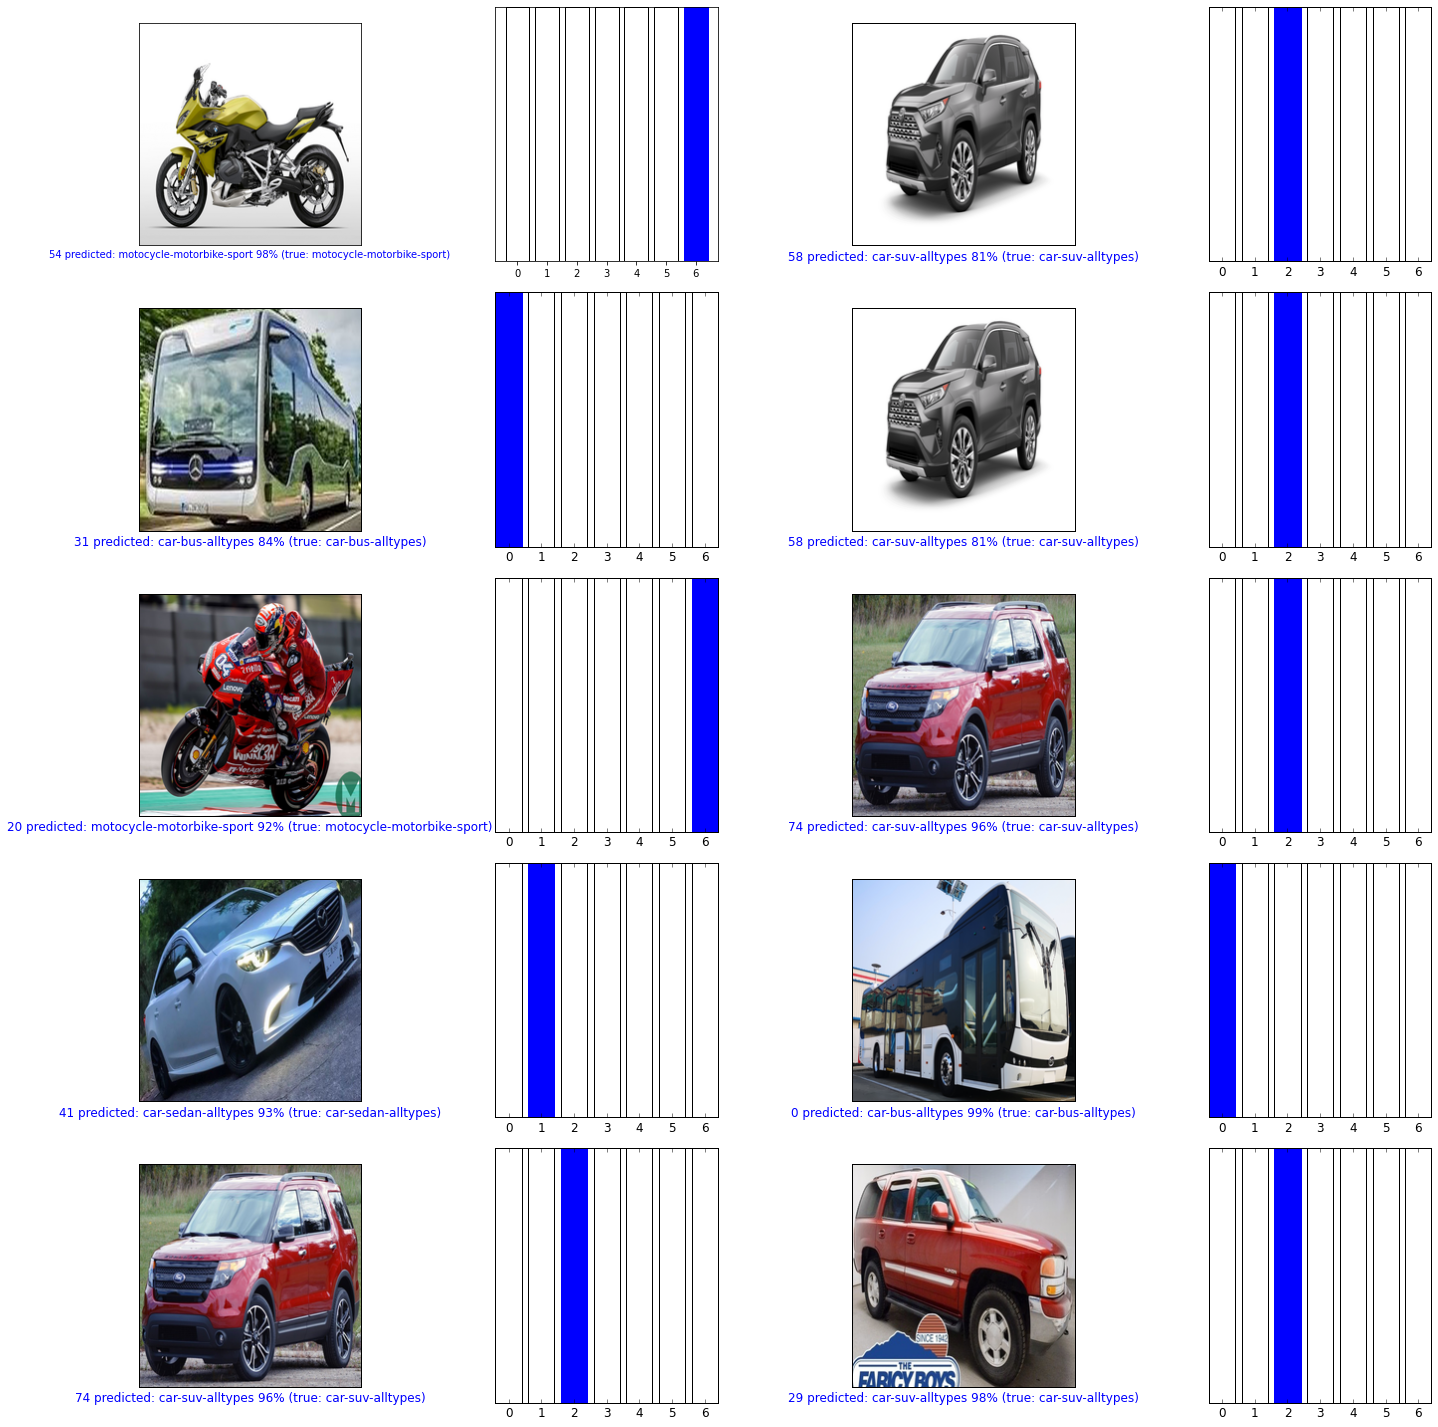

In [ ]:
#classes_names=['covid', 'normal']
#print(testX.shape)
#print(test_binary_labels.shape)
#anis_koubaa_udemy_computer_vision_lib.plot_car_sample_predictions(testX, prediction_array_all_test_dataset, testY, number_of_classes=42, num_rows = 20, num_cols = 1, width=30, height=40,is_random=True)
anis_koubaa_udemy_computer_vision_lib.plot_car_sample_predictions_v2(testX, testY, testLabels, prediction_array_all_test_dataset, num_rows = 5, num_cols = 2, width=20, height=20, is_random=True, plot_bars=True)

None
(224, 224)
RGB
(224, 224, 3)
(224, 224, 3)


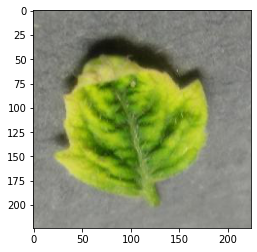

In [35]:
from PIL import Image
#test_image = Image.open(PROJECT_PATH+'test-images/bus.jpg')
test_image = Image.open(PROJECT_PATH+'Some_test_images/Tomato___Tomato_Yellow_Leaf_Curl_Virus-3.jpg')

IMAGE_SIZE=224

test_image = test_image.resize((IMAGE_SIZE, IMAGE_SIZE))

print(test_image.format)
print(test_image.size)
print(test_image.mode)
test_image = np.array(test_image)
print (test_image.shape)
if (test_image.shape[2]>3): #sometime the image comes with RGBA with 4 channels
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGRA2BGR)
print (test_image.shape)
x=plt.imshow(test_image)

In [36]:
#reshaped_test_image = anis_koubaa_udemy_computer_vision_lib.reshape_image_for_neural_network_input(test_image, IMAGE_SIZE=224,normalize=True)
from PIL import Image
from tensorflow.keras.utils import img_to_array
import cv2
t0 = datetime.datetime.now()
#IMAGE_SIZE = 224
#img = cv2.resize(test_image, (IMAGE_SIZE, IMAGE_SIZE))
img = test_image  # already resized above
# convert to array
img = img_to_array(img)
# reshape into a single sample with 3 channels
reshaped_image = img.reshape(1, 224, 224, 3)

#prediction_my_image = test_model.predict(reshaped_test_image)
prediction_my_image = test_model.predict(reshaped_image)
print(prediction_my_image)
class_dict[np.argmax(prediction_my_image)]


1/1 [==============================] - 0s 20ms/step
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


'Tomato___Early_blight'

In [37]:
def top_five(prediction_my_image, class_dict):
    sorted_array=np.argsort(prediction_my_image)[0][-5:]
    sorted_array=np.flip(sorted_array)
    sorted_array
    for s in sorted_array:
    #print(class_dict[s])
    #print('id:',s,', brand:'+class_dict[s]+', confidence:',prediction_my_image[0,s])
        print('id: %3d, brand:%-10s, confidence: %6.3f'%(s,class_dict[s],prediction_my_image[0,s]))

In [38]:
top_five(prediction_my_image, class_dict)

id:   1, brand:Tomato___Early_blight, confidence:  1.000
id:   9, brand:Tomato___healthy, confidence:  0.000
id:   8, brand:Tomato___Tomato_mosaic_virus, confidence:  0.000
id:   7, brand:Tomato___Tomato_Yellow_Leaf_Cu, confidence:  0.000
id:   6, brand:Tomato___Target_Spot, confidence:  0.000


In [39]:
#from tensorflow.keras.utils import img_to_array
#import cv2

def estimate_label(x):
  t0 = datetime.datetime.now()
  IMAGE_SIZE = 224
  img = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
  # convert to array
  img = img_to_array(img)
  # reshape into a single sample with 3 channels
  reshaped_image = img.reshape(1, 224, 224, 3)
  prediction_array = test_model.predict(reshaped_image, verbose = 0)
  predicted_label= np.argmax(prediction_array[0])
  t1 = datetime.datetime.now()
  #print("Time to predict: ", t1-t0)
  return predicted_label

In [40]:
#checking script for predicted label based on one input image
index= 84                     #30
test_image = testX[index]
result = estimate_label(test_image)
print(result)

7


In [41]:
# checking script for true label and predicted label 
for idx, x in enumerate(testX[0:5]):
    #print(idx, x)
    true_label= np.argmax(testY[idx])
    print("true label:", true_label)

    # Get predicted label from your classifier
    predicted_label = estimate_label(x)
    print("predicted label:", predicted_label)

true label: 9
predicted label: 9
true label: 3
predicted label: 3
true label: 4
predicted label: 4
true label: 4
predicted label: 4
true label: 0
predicted label: 0


In [42]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(testX_image, testY_image, testLabels_image):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []
   
    # Iterate through all the test images
    # Classify each image and compare to the true label

    for idx, x in enumerate(testX_image):
        #print(idx, x)
        true_label= np.argmax(testY_image[idx])

        # Get predicted label from your classifier
        predicted_label = estimate_label(x)
        #predicted_label= np.argmax(predict_array[0])
        
       # print("predicted label:", predicted_label, "   True label: ", true_label)
        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((x, idx, predicted_label, true_label))
            
            
    # Return the list of misclassified [image, misclassified index, predicted_label, true_label] values
    return misclassified_images_labels

In [63]:
# Find all misclassified images in a given test set
t0=datetime.datetime.now()
MISCLASSIFIED = get_misclassified_images(testX, testY, testLabels)
t1=datetime.datetime.now()

# Accuracy calculations
total = len(testX)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total


print('accuracy: ' + str(accuracy))
print("number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))
print('number of images: ' + str(total))
#print('rate of missclassfications: ' + str((len(MISCLASSIFIED)/(total))* 100)) 
print('rate of missclassifications: %.3f%%' % ((len(MISCLASSIFIED)/(total))* 100))
print('time to find misclassifications: ',(t1-t0))


accuracy: 0.95
number of misclassified images = 54 out of 1080
number of images: 1080
rate of missclassifications: 5.000%
time to find misclassifications:  0:00:42.662991


In [64]:
#print index to list of misclassfied items
t1 = [item[1] for item in MISCLASSIFIED]
print(t1)

[22, 47, 64, 81, 85, 118, 125, 162, 168, 202, 235, 251, 256, 288, 292, 298, 341, 349, 391, 396, 403, 432, 486, 487, 516, 535, 569, 574, 583, 584, 601, 615, 630, 633, 697, 740, 744, 774, 789, 796, 801, 840, 856, 898, 916, 921, 958, 1032, 1043, 1046, 1049, 1064, 1069, 1076]


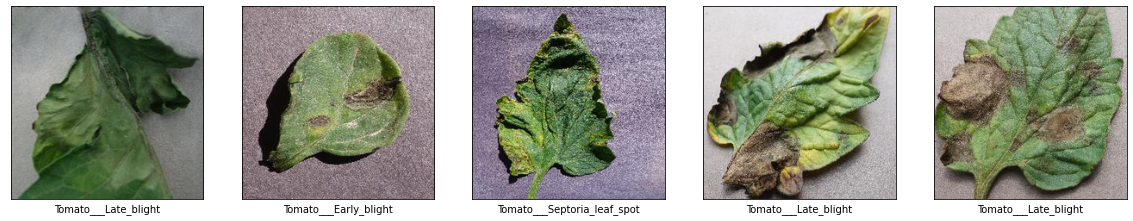

In [45]:
#Display images of the misclassified tomato leaves in the test dataset with true or actual disease labels
t1few=t1[0:5]
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX[t1few], testLabels[t1few],rows=1, colums=5, width=20,height=8)

In [46]:
class_dict

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spot',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Cu',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


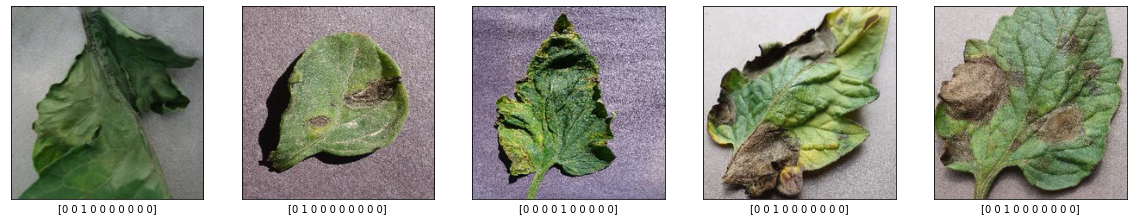

In [47]:
#Display images of the misclassified tomato leaves in the test dataset with true or actual binarized labels
t1few=t1[0:5]
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX[t1few], testY[t1few],rows=1, colums=5, width=20,height=8)

In [49]:
#What were they wrongly predicted as?
#print wrongly predicted labels to the list of misclassfied diseased tomaoto leaves
t2 = [item[2] for item in MISCLASSIFIED]
# print (wrongly) predicted labels to all 137 misidentified leaves 
print(t2)
# print (wrongly) predicted labels to first five misidentified leaves 
print(t2[0:5])

from sklearn.preprocessing import label_binarize

y_test_binarize = label_binarize(t2[0:5], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_test_binarize

[1, 3, 9, 1, 1, 2, 8, 9, 9, 5, 2, 0, 1, 1, 1, 3, 9, 0, 5, 1, 7, 7, 5, 6, 3, 1, 3, 2, 3, 1, 5, 3, 5, 5, 8, 1, 0, 2, 2, 1, 5, 3, 1, 2, 2, 3, 9, 8, 3, 6, 5, 2, 2, 8]
[1, 3, 9, 1, 1]


array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


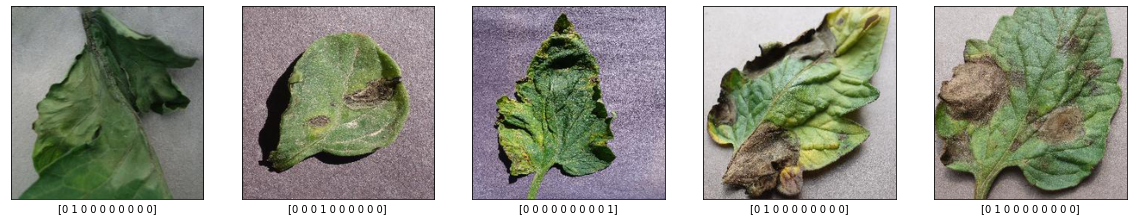

In [50]:
#Display images of the misclassified tomato leaves in the test dataset with false predicted binarized labels
t1few=t1[0:5]
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX[t1few], y_test_binarize, rows=1, colums=5, width=20,height=8)

In [51]:
print([class_dict[np.argmax(item)] for item in y_test_binarize])


['Tomato___Early_blight', 'Tomato___Leaf_Mold', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Early_blight']


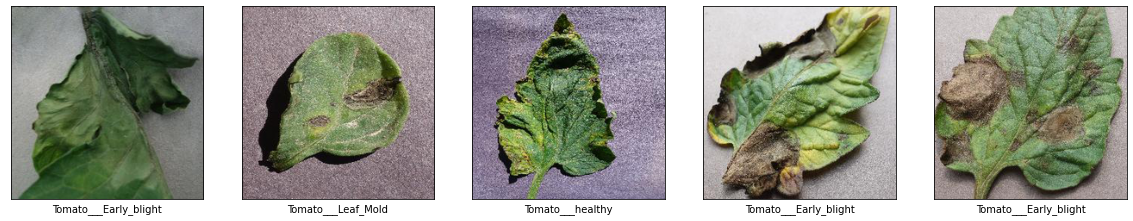

In [52]:
#Display images of the missclassified tomato leaves in the test dataset with false predicted disease labels
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX[t1few], ([class_dict[np.argmax(item)] for item in y_test_binarize]), rows=1, colums=5, width=20,height=8)

In [ ]:
#Now for the validation dataset:

In [53]:
# Find all misclassified images in the validation dataset
t0=datetime.datetime.now()
MISCLASSIFIED = get_misclassified_images(devX, devY, devLabels)
t1=datetime.datetime.now()

# Accuracy calculations
total = len(devX)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total


print('accuracy: ' + str(accuracy))
print("number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))
print('number of images: ' + str(total))
#print('rate of missclassfications: ' + str((len(MISCLASSIFIED)/(total))* 100)) 
print('rate of missclassifications: %.3f%%' % ((len(MISCLASSIFIED)/(total))* 100))
print('time to find misclassifications: ',(t1-t0))


accuracy: 0.9601482854494903
number of misclassified images = 43 out of 1079
number of images: 1079
rate of missclassifications: 3.985%
time to find misclassifications:  0:00:43.035860


In [54]:
#print index to list of misclassfied items
v1 = [item[1] for item in MISCLASSIFIED]
print(v1)

[5, 17, 42, 77, 83, 98, 107, 131, 210, 233, 240, 250, 280, 346, 365, 366, 370, 389, 395, 400, 423, 487, 550, 571, 572, 624, 637, 652, 679, 684, 746, 751, 827, 873, 887, 915, 996, 1004, 1017, 1032, 1040, 1051, 1061]


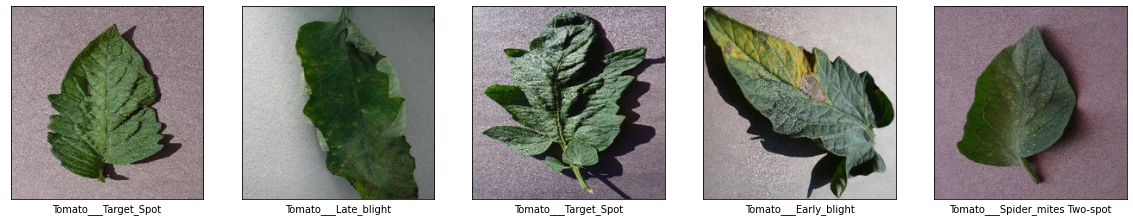

In [65]:
#Display images of the missclassified tomato leaves in the validation dataset with true or actual disease labels
v1few=v1[0:5]
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX[v1few], devLabels[v1few],rows=1, colums=5, width=20,height=8)

In [66]:
class_dict

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___Leaf_Mold',
 4: 'Tomato___Septoria_leaf_spot',
 5: 'Tomato___Spider_mites Two-spot',
 6: 'Tomato___Target_Spot',
 7: 'Tomato___Tomato_Yellow_Leaf_Cu',
 8: 'Tomato___Tomato_mosaic_virus',
 9: 'Tomato___healthy'}

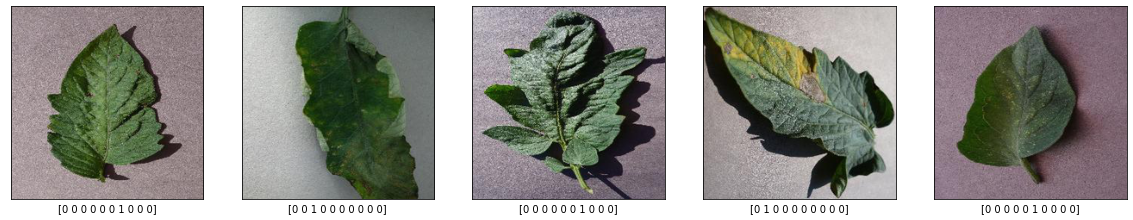

In [67]:
#Display images of the missclassified tomato leaves in the test dataset with true or actual binarized labels
v1few=v1[0:5]
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX[v1few], devY[v1few],rows=1, colums=5, width=20,height=8)

In [68]:
#What were they (some of the images in validation dataset) wrongly predicted as?
#print wrongly predicted labels to the list of misclassfied diseased tomaoto leaves
v2 = [item[2] for item in MISCLASSIFIED]
# print (wrongly) predicted labels to all 137 misidentified leaves 
print(v2)
# print (wrongly) predicted labels to first five misidentified leaves 
print(v2[0:5])

from sklearn.preprocessing import label_binarize

y_test_binarize = label_binarize(v2[0:5], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_test_binarize

[1, 3, 9, 1, 1, 2, 8, 9, 9, 5, 2, 0, 1, 1, 1, 3, 9, 0, 5, 1, 7, 7, 5, 6, 3, 1, 3, 2, 3, 1, 5, 3, 5, 5, 8, 1, 0, 2, 2, 1, 5, 3, 1, 2, 2, 3, 9, 8, 3, 6, 5, 2, 2, 8]
[1, 3, 9, 1, 1]


array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


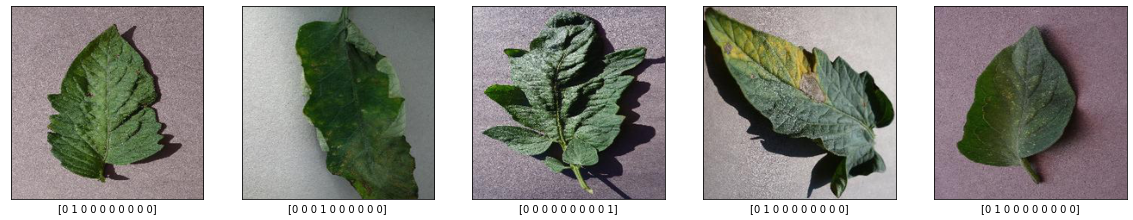

In [69]:
#Display images of the missclassified tomato leaves in the test dataset with false predicted binarized labels
v1few=v1[0:5]
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX[v1few], y_test_binarize, rows=1, colums=5, width=20,height=8)

In [70]:
print([class_dict[np.argmax(item)] for item in y_test_binarize])

['Tomato___Early_blight', 'Tomato___Leaf_Mold', 'Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Early_blight']


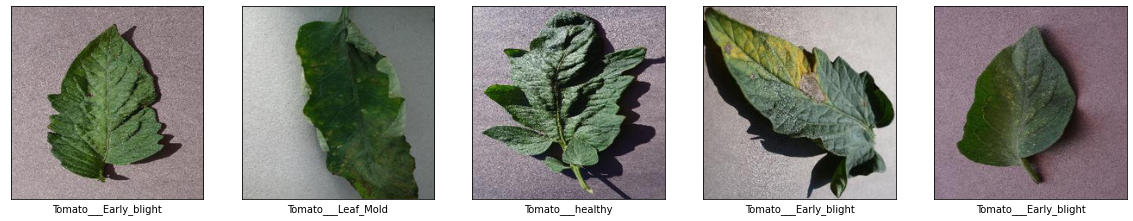

In [71]:
#Display images of the missclassified tomato leaves in the test dataset with false predicted disease labels
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX[v1few], ([class_dict[np.argmax(item)] for item in y_test_binarize]), rows=1, colums=5, width=20,height=8)

In [ ]:
#Ignore below script as those did not work

number of misclassications:  3
number of images: 75
rate of misclassications:  4.0 %
{6: ['motocycle-bicycle-racing', 'motocycle-motorbike-chopper'], 40: ['car-suv-alltypes', 'car-sedan-alltypes'], 46: ['motocycle-bicycle-racing', 'motocycle-bicycle-kids']}


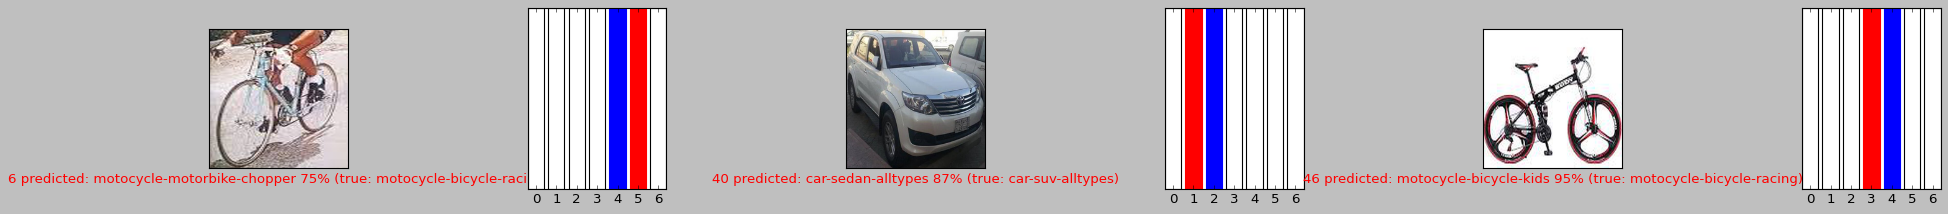

time to find misclassifications:  0:00:00.513404


In [ ]:
t0=datetime.datetime.now()
ms_test=anis_koubaa_udemy_computer_vision_lib.plot_misclassifications(testX, testY, testLabels, prediction_array_all_test_dataset, num_rows =15 , num_cols=5, width=40, height=40, is_random=False, plot_bars=True)
t1=datetime.datetime.now()
print('time to find misclassifications: ',(t1-t0))

In [ ]:
prediction_array_all_dev_dataset = test_model.predict(devX, verbose=1)

3/3 [==============================] - 0s 19ms/step


number of misclassications:  2
number of images: 75
rate of misclassications:  2.6666666666666665 %
{1: ['motocycle-motorbike-chopper', 'motocycle-motorbike-sport'], 53: ['car-suv-alltypes', 'car-sedan-alltypes']}


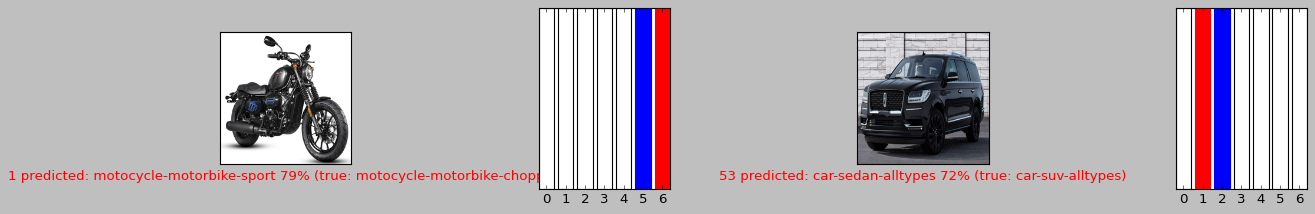

time to find misclassifications:  0:00:00.301496


In [ ]:

t0=datetime.datetime.now()
ms_dev=anis_koubaa_udemy_computer_vision_lib.plot_misclassifications(devX, devY, devLabels, prediction_array_all_dev_dataset, num_rows =15 , num_cols=5, width=40, height=40, is_random=False, plot_bars=True)
t1=datetime.datetime.now()
print('time to find misclassifications: ',(t1-t0))